# Final Machine Learning Pipeline

In this notebook, we will set up all the feature engineering steps within a Scikit-learn pipeline utilizing the open source transformers plus those we developed in house.

The pipeline features:

- open source classes
- in house package classes
- only the selected features

In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# for saving the pipeline
import joblib

# from scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# from feature engine
from feature_engine.selection import DropFeatures

# created in-house
import preprocessors as pp

In [2]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

In [3]:
# load dataset
data = pd.read_csv('student-mat.csv',sep=';')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


# Separate dataset into train and test

It is important to separate our data intro training and testing set.

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [4]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['G1','G2','G3'],axis=1), 
    data['G3'], 
    test_size=0.3, 
    random_state=0)

In [5]:
X_train.shape, X_test.shape

((276, 30), (119, 30))

# Configuration

In [6]:
# binary variables in the train set
BINARY_VARS = ['school',
               'sex',
               'address',
               'famsize',
               'Pstatus',
               'schoolsup',
               'famsup',
               'paid',
               'activities',
               'nursery',
               'higher',
               'internet',
               'romantic']

# non-binary variables in the train set
NON_BINARY_VARS = ['Mjob', 
                   'Fjob', 
                   'reason', 
                   'guardian']

# continuous variables that will require scaling
SCALED = ['age',
          'Medu',
          'Fedu',
          'Mjob',
          'Fjob',
          'guardian',
          'traveltime',
          'studytime',
          'failures']

# target variable for non-parametric ranking
TARGET = 'G3'

# unneeded features with high p-values and low effect sizes
DROPPED_FEAT = ['reason',
                'famrel',
                'freetime',
                'goout',
                'Dalc',
                'Walc',
                'health',
                'absences',
                'school_MS',
                'sex_M',
                'famsize_LE3',
                'Pstatus_T',
                'famsup_yes',
                'paid_yes',
                'activities_yes',
                'nursery_yes',
                'internet_yes',
                'romantic_yes']

# Pipeline - End-to-end

We have 5 steps less, commented out:

- encoding of binary variables
- encoding of non-binary variables
- scaling the continuous variables
- drop the unneeded features
- train the model with lasso regression

In [7]:
# set up the pipeline
grade_pipe = Pipeline([
    
    # ===== ENCODING =====
    # encoding of categorical binary variables
    ('binary_encoder', pp.CategoricalEncoder(variables=BINARY_VARS)),
    
    # encoding of categorical non-binary variables
    ('non_binary_encoder', pp.OrdinalEncoder(
        variables=NON_BINARY_VARS, target=TARGET)),
    
    # ===== SCALER =====
    # scale the continuous variables
    ('scaler', pp.ContinuousScaler(variables=SCALED)),
    
    # ===== DROP FEATURES =====
    # reduce dataset to selected features
    ('drop_features', DropFeatures(features_to_drop=DROPPED_FEAT)),
    
    ('Lasso', Lasso(alpha=0.001, random_state=0)),
    
])

In [8]:
# train the pipeline
grade_pipe.fit(X_train,y_train)

Pipeline(steps=[('binary_encoder',
                 <preprocessors.CategoricalEncoder object at 0x11cb464c0>),
                ('non_binary_encoder',
                 <preprocessors.OrdinalEncoder object at 0x11cb46640>),
                ('scaler',
                 <preprocessors.ContinuousScaler object at 0x11cb466a0>),
                ('drop_features',
                 DropFeatures(features_to_drop=['reason', 'famrel', 'freetime',
                                                'goout', 'Dalc', 'Walc',
                                                'health', 'absences',
                                                'school_MS', 'sex_M',
                                                'famsize_LE3', 'Pstatus_T',
                                                'famsup_yes', 'paid_yes',
                                                'activities_yes', 'nursery_yes',
                                                'internet_yes',
                                                'romant

In [9]:
# evaluate the model:
# ====================

# make predictions for train set
pred = grade_pipe.predict(X_train)

# determine mse, rmse and r2
print(f'train mse: {int(mean_squared_error(y_train, pred))}')
print(f'train rmse: {(int(mean_squared_error(y_train, pred)))**0.5}')
print(f'train r2: {r2_score(y_train, pred)}')
print()

# make predictions for test set
pred = grade_pipe.predict(X_test)

# determine mse, rmse and r2
print(f'test mse: {int(mean_squared_error(y_test, pred))}')
print(f'test rmse: {(int(mean_squared_error(y_test, pred)))**0.5}')
print(f'test r2: {r2_score(y_test, pred)}')
print()

print(f'Average grade score: {y_train.median()}')

train mse: 14
train rmse: 3.7416573867739413
train r2: 0.20020309622212784

test mse: 27
test rmse: 5.196152422706632
test r2: 0.024123499162753248

Average grade score: 11.0


Identical results to when we did the engineering manually.

Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

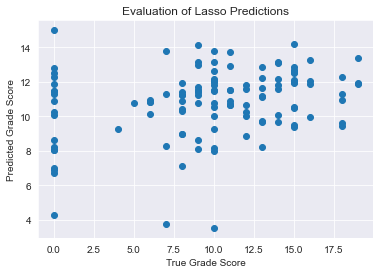

In [10]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, grade_pipe.predict(X_test))
plt.xlabel('True Grade Score')
plt.ylabel('Predicted Grade Score')
plt.title('Evaluation of Lasso Predictions')

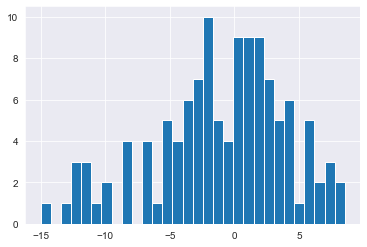

In [11]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(grade_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [12]:
# now let's save the scaler

joblib.dump(grade_pipe, 'grade_pipe.joblib') 

['grade_pipe.joblib']

To the extent that the model is efficient, we can go ahead and deploy!